In [1]:
import numpy as np
import networkx as nx
# import rustworkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from itertools import islice
# %matplotlib qt

import shapely
import matplotlib.patheffects as pe
import contextily as cx
import json

In [2]:
def distribute(needs,space): #distributes cars, there might be a faster way, but i cannot think of one right now
    endresult=np.zeros(len(needs),dtype=int)
    # filter=needs
    while space>=np.sum((needs>0)):
        add=min(np.min(needs[needs>0]),space//np.sum((needs>0)))
        endresult[needs>0]+=add
        space-=add*np.sum((needs>0))
        needs[needs>0]-=add
    endresult[np.nonzero(needs>0)[0][:space]]+=1
    return endresult
class edge(object):
    def __init__(self,length,speed,lanes,laneboundaries=None,id=0):
        self.length = int(length)
        self.lanes = int(lanes)
        if laneboundaries==None: laneboundaries=(int(lanes),int(lanes))
        self.basespeed=int(speed)
        self.speed=int(speed)
        self.cars = np.zeros((int(lanes*length/(4.5+speed/1.8)),5)) #collums: occupied,age,remaining travel time, spawnpoint, destination
        self.C0=int(lanes*length/(4.5+speed/1.8))
        self.Cmax=int(laneboundaries[1]*length/(4.5+speed/1.8))
        self.id=id
        self.leftthismin_avg=0
        self.leftthismin=0
        self.minlanes,self.maxlanes=laneboundaries
    def __str__(self): 
        return f"edge {self.id} cars:{np.sum(self.cars[:,0])}"
    def __repr__(self): 
        return f"edge {self.id} cars:{np.sum(self.cars[:,0])}"
    def C(self): #capacity of edge
        return int(self.lanes*self.length/(4.5+self.speed/1.8))
    def tto(self):
        return self.length/self.speed*60/1000
    def update(self):
        Filter = np.nonzero(self.cars[:,0]==1)[0] #Filter for 
        self.cars[Filter,2] -= 1 #travelled one minute
        self.cars[Filter,1] += 1 #aged one minute
        if self.size()>0.9*self.C():
            if self.lanes<self.maxlanes:
                print(f"spitsstrook open op {self}")
                self.lanes+=1
                self.cars=np.concatenate((self.cars,np.zeros((self.C()-len(self.cars),5))))
            elif self.size()>0.9*self.Cmax and self.speed>0.5*self.basespeed:
                print(f"file op {self},speed is now {self.speed}")
                self.speed-=.1*self.basespeed
                self.cars=np.concatenate((self.cars,np.zeros((self.C()-len(self.cars),5))))
        self.leftthismin_avg=(1-smoothing)*self.leftthismin_avg+smoothing*self.leftthismin
        self.leftthismin=0
    def tt_avg(self):
        if np.sum(self.cars[:,0])==0: return self.tto()*0.1 #defaults to tt0 if road is empty
        else: return (max(np.sum(self.cars[self.cars[:,2]>0,2]),1)/np.sum(self.cars[:,0])) #otherwise average the traveltime
    def avg_waittime(self):
        """average time a car waits to pass through node"""
        if np.sum(self.cars[:,2]<0)==0: return 0
        else: return -np.average(self.cars[self.cars[:,2]<0,2])
    def tt(self):
        return self.tto()*(1+0.15*(self.size()/self.C())**4)
    def size(self):
        return sum(self.cars[:,0])
class node(object):
    def __init__(self,inputs=[],output=[],destinations=[],id=0,average=85,sd=1.5):
        self.id=id
        self.output = output
        self.input = inputs
        self.destinations=destinations
        self.dest_weights=[]
        self.waitlist=dict(zip(self.output,[dict(zip(self.input,[np.zeros(0,dtype=int) for j in self.input]))for i in self.output]))
        for i in self.waitlist.keys():
            self.waitlist[i]["self"]=np.array([],dtype=int)        
        self.buildup=np.zeros((0,5))
        self.times=np.zeros((0,2)) #array with first collumn as times, and second as origins
        self.choices=np.empty(0,dtype=edge)
        self.gen_average=average
        self.gen_sd=sd
    def initwaitlist(self):
        if len(self.waitlist.keys())>0: print("waitlist already had keys",self.waitlist); return
        else: self.waitlist=dict(zip(self.output,[dict(zip(self.input,[np.zeros(0,dtype=int) for j in self.input]))for i in self.output]))
    def __str__(self): 
        if len(self.buildup): return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]} and buildup:{len(self.buildup)}"
        else: return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]}"
    def __repr__(self): 
        if len(self.buildup): return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]} and buildup:{len(self.buildup)}"
        else: return f"node {self.id} with input: {[i.id for i in self.input]} and output: {[i.id for i in self.output]}"
    def size(self):
        return len(self.buildup)    
    def avg_waittime(self,edge_out):
        if edge_out not in self.output: print(f"what ya doing mate {edge_out} does not exit {self}")
        carswaiting=np.concatenate([i.cars[self.waitlist[edge_out][i],2] for i in self.input])
        if len(carswaiting)==0: return 0.00001
        else:return -np.average(carswaiting)
    def flow(self):
        for i in self.input: #putting stuff in waitlist
            Remove=np.nonzero(np.logical_and(i.cars[:,4]==self.id,np.logical_and(i.cars[:,2]<=0,i.cars[:,0]==1)))[0]
            self.times=np.concatenate((self.times,i.cars[Remove,:][:,[1,3]])) #remove all cars that have arrived at their destination
            i.cars[Remove,:]=0
            i.leftthismin+=len(Remove)
            # if self.id==2: print(f"recieved {len(Remove)} cars from {i}")
            if self.output==[]:print(f"node {self.id} had no output roads") ;continue
            Filter2 = np.nonzero(np.logical_and(i.cars[:,2]==0,i.cars[:,0]==1))[0] #check which cars arrived now
            if len(self.output)==len(self.input)==2: choices=np.full(len(Filter2),[edges for edges in self.output if edges.id !=(i.id[1],i.id[0])][0]) #cars are not allowed to go back, so this is the only option for cars
            elif len(self.output) == 1:
                choices = np.full(len(Filter2), self.output[0])
            else:
                handling=i.cars[Filter2,:] #cars that need to be handled this function call
                choices=np.empty(len(handling),dtype=edge)
                for dest in np.unique(handling[:,4]):
                    routes=list(islice(nx.shortest_simple_paths(gfd,self.id,dest,weight="tt_avg"),len(self.output)-1))
                    a=[gfd.edges[path[:2]]["object"]for path in routes]
                    if len(a) == 0:
                        print(f"self = {self}")
                        print(f"routes = {routes}")
                        print(f"dest = {dest}")
                    weights=1/np.array([nx.path_weight(gfd,path,weight="tt_avg") for path in routes])
                    rander=np.random.choice(a,size=sum(handling[:,4]==dest),p=weights/np.sum(weights)) #randomly choose next edge
                    choices[handling[:,4]==dest]=rander
            for indexes in choices:
                if indexes not in self.output: print("fuck")
            for j in self.output:
                self.waitlist[j][i]=np.concatenate((self.waitlist[j][i],np.array(Filter2[choices==j],dtype=int))) #add new indexes along with their location at the end
        if len(self.buildup)-len(self.choices)>0: #handle buildup caused by generate
            handling=self.buildup[len(self.choices)-len(self.buildup):] #self.buildup[len(self.choices)-len(self.buildup):] should be the cars not handled yet
            if len(self.output)==1: choices=np.full(len(self.buildup)-len(self.choices),self.output[0])
            elif len(self.output)==len(self.input)==2: choices=np.array([gfd.edges[paths[self.id][endgoal][:2]]["object"] for endgoal in handling[:,4]]) #2 edges means we only randomly choose out of 1 option, so might as well take that one immediatly
            else:   
                choices=np.empty(len(handling),dtype=edge)
                for dest in np.unique(handling[:,4]): 
                    routes=list(islice(nx.shortest_simple_paths(gfd,self.id,dest,weight="tt_avg"),len(self.output)-1))
                    a=[gfd.edges[path[:2]]["object"]for path in routes]
                    weights=1/np.array([nx.path_weight(gfd,path,weight="tt_avg") for path in routes])
                    rander=np.random.choice(a,size=sum(handling[:,4]==dest),p=weights/np.sum(weights)) #randomly choose next edge
                    choices[handling[:,4]==dest]=rander
            self.choices=np.concatenate((self.choices,choices))
            if len(self.choices)!=len(self.buildup): print("oi wtf")
            for o in self.output:
                self.waitlist[o]["self"]=np.nonzero(self.choices==o)[0]
                # if testing_buildup==True: print(self.waitlist[o]["self"],self,o)
        elif self.id in list(sources):
            # print("no buildup on",self)
            for o in self.output:
                self.waitlist[o]["self"]=np.array([],dtype=int)
        for i in self.output:#getting stuff out of waitlist
            if sum([len(self.waitlist[i][j]) for j in self.input])+len(self.waitlist[i]["self"])==0: continue #doesn't need to do anything if there are no cars waiting
            elif sum([len(self.waitlist[i][j]) for j in self.input])+len(self.waitlist[i]["self"])<=np.sum(i.cars[:,0]==0):
                for j in self.input:
                    Filter=np.nonzero(i.cars[:,0]==0)[0][:len(self.waitlist[i][j])]
                    j.leftthismin+=len(Filter)
                    i.cars[Filter]=j.cars[self.waitlist[i][j],:] #put cars in next edge
                    i.cars[Filter,2]=np.maximum(np.ceil(i.tt()+np.random.normal(0,i.tto()/10,size=len(Filter))),1)
                    j.cars[self.waitlist[i][j],:]=0 #empty the cars
                    self.waitlist[i][j]=np.zeros(0,dtype=int) #empty waitlist
                Filter=np.nonzero(i.cars[:,0]==0)[0][:len(self.waitlist[i]["self"])]
                i.cars[Filter]=self.buildup[self.waitlist[i]["self"],:]
                i.cars[Filter,2]=np.maximum(np.ceil(i.tt()+np.random.normal(0,i.tto()/10,size=len(Filter))),1)
                self.buildup[self.waitlist[i]["self"],0]=0
            else:
                space=np.sum(i.cars[:,0]==0)
                needs=np.array([len(self.waitlist[i][j]) for j in self.input]+[len(self.waitlist[i]["self"])])
                allowances=distribute(needs,space)
                for k,j in enumerate(self.input):
                    j.leftthismin+=allowances[k]
                    Filter=np.nonzero(i.cars[:,0]==0)[0][:allowances[k]]
                    i.cars[Filter]=j.cars[self.waitlist[i][j][:allowances[k]]] ###probs dont need [Filtertje,:] [Filtertje] seems enough
                    i.cars[Filter,2]=np.maximum(np.ceil(i.tt()+np.random.normal(0,i.tto()/10,size=len(Filter))),1)
                    j.cars[self.waitlist[i][j][:allowances[k]],:]=0 #empty the cars
                    self.waitlist[i][j]=self.waitlist[i][j][allowances[k]:]
                #handle buildup
                Filter=np.nonzero(i.cars[:,0]==0)[0][:allowances[-1]]
                i.cars[Filter]=self.buildup[self.waitlist[i]["self"][:allowances[-1]]] ###probs dont need [Filtertje,:] [Filtertje] seems enough
                i.cars[Filter,2]=np.maximum(np.ceil(i.tt()+np.random.normal(0,i.tto()/10,size=len(Filter))),1)
                self.buildup[self.waitlist[i]["self"][:allowances[-1]],0]=0 #empty the cars
    def generate(self,destinations=[2]): ##change code to account for more generating cities and differing distributions
        N=max(0, int(np.random.normal(self.gen_average,self.gen_sd)+0.5)) #+.5 rounds it to the nearest integer
        self.choices=self.choices[self.buildup[:,0]!=0]
        self.buildup=self.buildup[self.buildup[:,0]!=0]
        # self.buildup[:,1]+=1 #only leave if we allow cars to age while waiting in cities
        newcars=np.array([np.ones(N),np.zeros(N),np.random.normal(0,1,size=N),np.full(N,self.id),np.random.choice(self.destinations,N,p=self.dest_weights)]).transpose()
        self.buildup=np.concatenate((self.buildup,newcars)) #needs to handle the built up cars first

# Initialization

In [3]:
pops=np.array([95890,44990,34105,15200,13060, 13355, 13015,12965,10370,10120,9960,30680])
20*12*pops/np.sum(pops)

array([75.77491686, 35.55233611, 26.95070956, 12.0114583 , 10.32037141,
       10.55348853, 10.28481117, 10.24529979,  8.19465938,  7.9971025 ,
        7.8706661 , 24.2441803 ])

In [4]:
smoothing=1/10
runnr=999
stadnamen=['Leeuwarden', 'Drachten', 'Sneek', 'Heerenveen', 'Harlingen','Joure', 'Wolvega', 'Franeker', 'Dokkum', 'Lemmer', 'Bolsward','Burgum']
# spawn_hoeveelheden={160: 12, 199: 25, 'Leeuwarden': 56, 'Drachten': 36, 'Sneek': 35, 'Harlingen': 13.086859668020224, 'Joure': 10, 'Wolvega': 11, 'Franeker': 10, 'Dokkum': 8.980727539476826, 'Lemmer': 10, 'Bolsward': 9.477514803509319, 'Burgum': 10, 'Heerenveen': 24}
spawn_hoeveelheden={
    160: 4.39, #oosterwolde
    199: 10.8, #afsluitdijk
    93: 33.86, # verbinding A7 Friesland-Groningen
    33: 3.7, # verbinding N355 Friesland-Groningen
    157: 4.56, # verbinding N919 Friesland-Drenthe (Assen)
    18: 10.14, # verbinding N381 Friesland-Drenthe
    181: 19.04, # verbinding A32 Friesland-Overijssel
    185: 24.02, # verbinding A6 Friesland-Flevoland
    'Leeuwarden': 42.9 * 1.5, 
    'Drachten': 32.1, # 20.1 
    'Sneek': 15.25 * 1.4, 
    'Harlingen': 6.8 * 1.2, 
    'Joure': 5.84 * 1.2, 
    'Wolvega': 5.97 * 1.2, 
    'Franeker': 5.83 * 1.2, 
    'Dokkum': 5.8 * 1.2,
    'Lemmer': 4.64 * 1.2,
    'Bolsward': 4.53 * 1.2, 
    'Burgum': 4.46 * 1.2,
    'Heerenveen': 13.7 * 1.4}

In [5]:
nodes_gpd = gpd.read_file('./wegengraafsimple/points.shp')
lines_gpd = gpd.read_file('./wegengraafsimple/lines.shp')

lines_gpd = lines_gpd.to_crs(epsg='28992')

def transform_length(row):
    row['length'] = row['geometry'].length
    return row

lines_gpd = lines_gpd.apply(transform_length, axis=1).to_crs(epsg='3857')

# r = lines_gpd[(lines_gpd['node_start'] == 149) & (lines_gpd['node_end'] == 91)]
# r = r.to_crs(crs="28992")
# r.length


# change_to_2=[(201,202),(202,35),(35,225),(225,105),"N356","031",(123,256),(256,219),(219,160)]
# def update_lanes_to2(row):
#     if (row["node_end"],row["node_start"]) in change_to_2 or (row["node_start"],row["node_end"]) in change_to_2 or row["wegnr"] in change_to_2:
#         row["nbanen"]=2
#     return row
# lines_gpd=lines_gpd.apply(update_lanes_to2,axis=1)
nodes_gpd["is_auto_br"][np.isnan(nodes_gpd["is_auto_br"])]=0
nodes_gpd["spawn_hoev"][np.isnan(nodes_gpd["spawn_hoev"])]=0
missing_length=np.nonzero(np.isnan(lines_gpd["length"]))[0]
for i in missing_length:
    lines_28992 = lines_gpd.to_crs(epsg=28992) # on average 1m accuracy, testing roughly gives the same result (1.92 km approx 2.00 km)
    lines_gpd.iloc[i,1]=lines_28992.length[i]
lines_gpd["capacity"]=lines_gpd['length']*lines_gpd['nbanen']*1/(4.5+lines_gpd['maxshd']/1.8)

for k, v in spawn_hoeveelheden.items():
    if type(k) == int:
        nodes_gpd["spawn_hoev"][nodes_gpd["nodeID"]==k],nodes_gpd["is_auto_br"][nodes_gpd["nodeID"]==k] = v, 1

# nodes_gpd["spawn_hoev"][nodes_gpd["nodeID"]==160],nodes_gpd["is_auto_br"][nodes_gpd["nodeID"]==160]=      spawn_hoeveelheden[160],1
# nodes_gpd["spawn_hoev"][nodes_gpd["nodeID"]==199],nodes_gpd["is_auto_br"][nodes_gpd["nodeID"]==199]=      spawn_hoeveelheden[199],1 #afsluitdijk
for name in stadnamen[1:]: #leeuwenwarden is handled seperately
    nodes_gpd["spawn_hoev"][nodes_gpd["stad_naam"]==name]=spawn_hoeveelheden[name]
nodes_gpd.loc[nodes_gpd["is_auto_br"]==2,"spawn_hoev"]=spawn_hoeveelheden["Leeuwarden"]/sum(nodes_gpd["is_auto_br"]==2) #spread Leeuwarden's spawns over the appropriate nodes

C:\Users\Alexander\AppData\Local\Temp\ipykernel_7876\173192829.py:23: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  nodes_gpd["is_auto_br"][np.isnan(nodes_gpd["is_auto_br"])]=0
C:\Users\Alexander\AppData\Local\Temp\ipykernel_7876\173192829.p

In [6]:
def create_graph(nodes_gpd, lines_gpd):
    gf = nx.Graph()
    for _, k in nodes_gpd.iterrows():
        gf.add_node(int(k['nodeID']),
                    x=k['geometry'].x,
                    y=k['geometry'].y,
                    stad_naam=k['stad_naam'],
                    is_auto_br=k['is_auto_br'],
                    spawn_hoev=k['spawn_hoev'])
    for _, row in lines_gpd.iterrows():
        gf.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])
    return gf

gfd = nx.DiGraph(create_graph(nodes_gpd, lines_gpd))

In [7]:
def weight_edge_min(f, t, attr):
    return attr['length']/attr['maxshd']/1000*60

def weight_edge_dist(f, t, attr):
    return attr['length']

def weight_capacity(f, t, attr):
    cars = np.sum(attr['object'].cars[:, 0])
    capacity = attr['object'].C()
    return attr['length']/attr['maxshd']/1000*60 * (1 + cars/capacity)

In [8]:
def draw_directed(gfd):
    gfd_dir = nx.DiGraph()
    for n in gfd.nodes():
        gfd_dir.add_node(n, x=gfd.nodes[n]['x'], y=gfd.nodes[n]['y'])

    for _, row in lines_gpd.iterrows():
        gfd_dir.add_edge(int(row['node_start']), int(row['node_end']),
                    wegnr=row['wegnr'],
                    length=row['length'],
                    maxshd=row['maxshd'],
                    nbanen=row['nbanen'])

    plt.figure(figsize=(20, 20))
    nx.draw(gfd_dir, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)}, with_labels=True, node_shape='s', node_size=1)

    # subgr = nx.DiGraph(gfd.subgraph(path))
    # nx.draw_networkx_edges(subgr, pos={n: [gfd.nodes[n]['x'], gfd.nodes[n]['y']] for n in list(gfd.nodes)},
    #                     edge_color=colors[i], width=15, style=style[i])
    # i += 1

    plt.show()

# draw_directed(gfd)

In [9]:
# parameters cell
minutes_simulation = 60
minutes_initialization = 0
save_to = None
traveltime_saveto = None
road_modifications = {}

In [10]:
# Parameters
minutes_initialization = 50
minutes_simulation = 100
save_to = "test9.csv"
traveltime_saveto = "traveltime9.bin"
road_modifications = {"175000197.0": {"nbanen": 3}, "169000197.0": {"nbanen": 3}, "168000169.0": {"nbanen": 3}, "189000168.0": {"nbanen": 3}, "149000189.0": {"nbanen": 3}}


In [11]:
def change_nbanen(edge, new_nbanen, lines_gpd):
    def _internal_transf(r):
        if (r['node_start'] == e1 and r['node_end'] == e2) or (r['node_start'] == e2 and r['node_end'] == e1):
            r['nbanen'] = new_nbanen
            r['capacity'] = r['length'] * r['nbanen'] * 1/(4.5 + r['maxshd']/1.8)
        return r
    
    e1, e2 = edge
    gfd.edges[(e1, e2)]['nbanen'] = new_nbanen
    gfd.edges[(e2, e1)]['nbanen'] = new_nbanen
    lines_gpd['length']*lines_gpd['nbanen']*1/(4.5+lines_gpd['maxshd']/1.8)
    return lines_gpd.apply(_internal_transf, axis=1)

def change_maxshd(edge, new_maxshd, lines_gpd):
    def _internal_transf(r):
        if (r['node_start'] == e1 and r['node_end'] == e2) or (r['node_start'] == e2 and r['node_end'] == e1):
            r['maxshd'] = new_maxshd
            r['capacity'] = r['length'] * r['nbanen'] * 1/(4.5 + r['maxshd']/1.8)
        return r
    
    e1, e2 = edge
    gfd.edges[(e1, e2)]['maxshd'] = new_maxshd
    gfd.edges[(e2, e1)]['maxshd'] = new_maxshd
    return lines_gpd.apply(_internal_transf, axis=1)

road_modifications = {(int(float(k) // 1e6), int(float(k) % 1e6)): v for k, v in road_modifications.items()}
for k, v in road_modifications.items():
    if 'nbanen' in v.keys():
        lines_gpd = change_nbanen(k, v['nbanen'], lines_gpd)
    if 'maxshd' in v.keys():
        lines_gpd = change_maxshd(k, v['maxshd'], lines_gpd)

In [12]:
# lines_gpd[(lines_gpd['node_start'] == 175) & (lines_gpd['node_end'] == 197)]

### Running the model

In [13]:
sources=nodes_gpd["nodeID"][np.nonzero(nodes_gpd["is_auto_br"])[0]]
weights=nodes_gpd["spawn_hoev"][np.nonzero(nodes_gpd["is_auto_br"])[0]]
leeuwarden=list(nodes_gpd[nodes_gpd["is_auto_br"]==2]["nodeID"])
# sources=[1000,1001,1002]
nx.set_edge_attributes(gfd,{e: edge(gfd.edges[e]["length"],gfd.edges[e]["maxshd"],gfd.edges[e]["nbanen"],id=e) for e in gfd.edges},"object") #put edge objects on the edges
nx.set_node_attributes(gfd,{n: node(inputs=[gfd.edges[e]["object"] for e in gfd.in_edges(n)],output=[gfd.edges[e]["object"] for e in gfd.out_edges(n)],id=n, average=gfd.nodes[n]["spawn_hoev"],sd=1.5) for n in gfd.nodes},"object") 
#put node objects on nodes
for i in sources:
    if i in leeuwarden:
        gfd.nodes[i]["object"].destinations=list(filter(lambda x: x not in leeuwarden, sources))
        gfd.nodes[i]["object"].dest_weights=list(weights[list(i not in leeuwarden for i in sources)]/sum(weights[list(i not in leeuwarden for i in sources)]))#destination is any city except source
    else:    
        gfd.nodes[i]["object"].destinations=list(sources[sources!=i])
        gfd.nodes[i]["object"].dest_weights=list(weights[sources!=i]/sum(weights[sources!=i])) #destination is any city except source
    if len(gfd.nodes[i]["object"].destinations)!=len(gfd.nodes[i]["object"].dest_weights): 
        raise ValueError(f"destinations and dest_weights not the same size for id:{i}")

In [14]:
minutes_init=0 #initialisation time
minutes_sim=180 #simulation time
if minutes_simulation: # simulation tag
    minutes_sim = minutes_simulation
if minutes_initialization:
    minutes_init = minutes_initialization

sources=nodes_gpd["nodeID"][np.nonzero(nodes_gpd["is_auto_br"])[0]]
# sources=[1000,1001,1002]

cars_forw=np.zeros((len(lines_gpd),minutes_sim))
cars_backw=np.zeros((len(lines_gpd),minutes_sim))
capacity=np.zeros((len(lines_gpd),minutes_sim))
def tt_avg(f, t, attr):
    return attr['object'].tt_avg()+attr['object'].avg_waittime() #average waittime is remaning time plus wait time at end of edge
for minute in range(minutes_init):
    nx.set_edge_attributes(gfd,{e: (gfd.edges[e]["object"].tt_avg()+gfd.nodes[e[0]]["object"].avg_waittime(gfd.edges[e]["object"]))*(1+gfd.edges[e]["object"].size()/gfd.edges[e]["object"].C()) for e in gfd.edges},"tt_avg") #put edge objects on the edges
    paths={n: b for (n, (a, b)) in nx.all_pairs_dijkstra(gfd, weight="tt_avg")}
    for i in sources:
        # print(i,gfd.nodes[i]["object"])
        gfd.nodes[i]["object"].generate() #generate cars at all sources
    for e in gfd.edges:
        # print(e,gfd.edges[e]["object"])
        gfd.edges[e]["object"].update()
    for n in gfd.nodes:
        # print(n,gfd.nodes[n]["object"])
        gfd.nodes[n]["object"].flow()
for i in sources: gfd.nodes[i]["object"].times=np.zeros((0,2))
for minute in range(minutes_sim):
    print(minute, end=', ')
    nx.set_edge_attributes(gfd,{e: (gfd.edges[e]["object"].tt_avg()+gfd.nodes[e[0]]["object"].avg_waittime(gfd.edges[e]["object"]))*(1+gfd.edges[e]["object"].size()/gfd.edges[e]["object"].C()) for e in gfd.edges},"tt_avg") #put edge objects on the edges
    paths={n: b for (n, (a, b)) in nx.all_pairs_dijkstra(gfd, weight="tt_avg")}
    for i in sources:
    # print(i,gfd.nodes[i]["object"])
        gfd.nodes[i]["object"].generate() #generate cars at all sources
    for e in gfd.edges:
        # print(e,gfd.edges[e]["object"])
        gfd.edges[e]["object"].update()
    for n in gfd.nodes:
        # print(n,gfd.nodes[n]["object"])
        gfd.nodes[n]["object"].flow()
    for index,(start,end) in enumerate(zip(lines_gpd["node_start"],lines_gpd["node_end"])):
        # if (start,end) in gfd.edges:
        cars_forw[index,minute]=gfd.edges[(start,end)]["object"].size()
        cars_backw[index,minute]=gfd.edges[(end,start)]["object"].size()
        capacity[index,minute]=gfd.edges[(end,start)]["object"].C()
        # else: continue

for i in range(9999):
    lines_gpd = lines_gpd.drop(columns=[f'f{i}'], errors='ignore')
    lines_gpd = lines_gpd.drop(columns=[f'b{i}'], errors='ignore')

cars_forw_pd=pd.DataFrame(cars_forw,columns=[f"f{i}" for i in range(minutes_sim)])
cars_backw_pd=pd.DataFrame(cars_backw,columns=[f"b{i}" for i in range(minutes_sim)])
lines_gpd=pd.concat((lines_gpd,pd.DataFrame(cars_forw_pd),cars_backw_pd),axis=1)


file op edge (1001, 246) cars:61.0,speed is now 50
file op edge (700, 608) cars:28.0,speed is now 50


file op edge (610, 601) cars:13.0,speed is now 50


file op edge (1001, 146) cars:75.0,speed is now 50
file op edge (706, 1000) cars:10.0,speed is now 50


file op edge (610, 601) cars:15.0,speed is now 45.0


file op edge (1001, 146) cars:75.0,speed is now 45.0
file op edge (700, 608) cars:31.0,speed is now 45.0


file op edge (700, 608) cars:34.0,speed is now 40.0
file op edge (702, 607) cars:15.0,speed is now 50


file op edge (1001, 246) cars:67.0,speed is now 45.0
file op edge (702, 607) cars:16.0,speed is now 45.0


file op edge (1001, 246) cars:71.0,speed is now 40.0
file op edge (1002, 240) cars:65.0,speed is now 50
file op edge (700, 608) cars:38.0,speed is now 35.0
file op edge (705, 600) cars:23.0,speed is now 50


file op edge (1002, 240) cars:64.0,speed is now 45.0


file op edge (702, 607) cars:17.0,speed is now 40.0


file op edge (702, 606) cars:26.0,speed is now 50


file op edge (701, 605) cars:37.0,speed is now 50


file op edge (1001, 146) cars:82.0,speed is now 40.0


file op edge (605, 6) cars:65.0,speed is now 65


file op edge (1001, 246) cars:83.0,speed is now 35.0
file op edge (702, 607) cars:19.0,speed is now 35.0
file op edge (705, 600) cars:24.0,speed is now 45.0


file op edge (215, 151) cars:24.0,speed is now 100
file op edge (605, 6) cars:66.0,speed is now 58.5


file op edge (215, 151) cars:25.0,speed is now 90.0
file op edge (608, 173) cars:49.0,speed is now 70


file op edge (702, 606) cars:28.0,speed is now 45.0


file op edge (215, 151) cars:29.0,speed is now 80.0
file op edge (1003, 149) cars:50.0,speed is now 50
file op edge (700, 608) cars:39.0,speed is now 30.0
file op edge (705, 600) cars:27.0,speed is now 40.0


file op edge (1001, 246) cars:97.0,speed is now 30.0
file op edge (606, 605) cars:16.0,speed is now 50


file op edge (1003, 149) cars:57.0,speed is now 45.0
file op edge (606, 605) cars:18.0,speed is now 45.0


file op edge (702, 607) cars:22.0,speed is now 30.0


file op edge (1001, 146) cars:91.0,speed is now 35.0


file op edge (149, 150) cars:111.0,speed is now 100


file op edge (149, 150) cars:122.0,speed is now 90.0
file op edge (1001, 146) cars:104.0,speed is now 30.0


file op edge (149, 150) cars:140.0,speed is now 80.0


file op edge (174, 173) cars:22.0,speed is now 80
file op edge (215, 151) cars:34.0,speed is now 70.0
file op edge (606, 605) cars:19.0,speed is now 40.0


file op edge (149, 150) cars:153.0,speed is now 70.0
file op edge (151, 150) cars:61.0,speed is now 100
file op edge (174, 173) cars:24.0,speed is now 72.0
file op edge (606, 605) cars:22.0,speed is now 35.0


file op edge (149, 150) cars:177.0,speed is now 60.0
file op edge (151, 150) cars:64.0,speed is now 90.0
file op edge (706, 702) cars:24.0,speed is now 50


file op edge (606, 605) cars:24.0,speed is now 30.0


file op edge (602, 201) cars:27.0,speed is now 70
file op edge (703, 108) cars:24.0,speed is now 100
file op edge (706, 1000) cars:11.0,speed is now 45.0


file op edge (607, 606) cars:20.0,speed is now 50
file op edge (702, 606) cars:31.0,speed is now 40.0
file op edge (706, 702) cars:28.0,speed is now 45.0


file op edge (607, 606) cars:22.0,speed is now 45.0


file op edge (607, 606) cars:23.0,speed is now 40.0
file op edge (703, 108) cars:29.0,speed is now 90.0
file op edge (705, 600) cars:30.0,speed is now 35.0
file op edge (706, 702) cars:30.0,speed is now 40.0


file op edge (91, 149) cars:264.0,speed is now 100
file op edge (1003, 149) cars:64.0,speed is now 40.0
file op edge (607, 606) cars:27.0,speed is now 35.0
file op edge (703, 108) cars:32.0,speed is now 80.0


file op edge (1003, 149) cars:74.0,speed is now 35.0
file op edge (702, 606) cars:32.0,speed is now 35.0


file op edge (174, 173) cars:26.0,speed is now 64.0


file op edge (215, 151) cars:37.0,speed is now 60.0
file op edge (607, 175) cars:92.0,speed is now 50
file op edge (700, 1000) cars:23.0,speed is now 30


0, 

1, 

2, 

3, 

file op edge (175, 607) cars:91.0,speed is now 50
file op edge (1003, 149) cars:81.0,speed is now 30.0
file op edge (700, 1000) cars:26.0,speed is now 27.0


4, 

file op edge (607, 606) cars:29.0,speed is now 30.0
file op edge (706, 1000) cars:12.0,speed is now 40.0


5, 

file op edge (91, 149) cars:289.0,speed is now 90.0
file op edge (705, 600) cars:35.0,speed is now 30.0


6, 

7, 

file op edge (174, 173) cars:31.0,speed is now 56.0
file op edge (1003, 224) cars:57.0,speed is now 50


8, 

9, 

file op edge (608, 173) cars:58.0,speed is now 63.0


10, 

file op edge (174, 173) cars:32.0,speed is now 48.0
file op edge (206, 146) cars:159.0,speed is now 100
file op edge (608, 173) cars:62.0,speed is now 56.0


11, 

file op edge (72, 173) cars:109.0,speed is now 100
file op edge (173, 72) cars:112.0,speed is now 100
file op edge (701, 605) cars:40.0,speed is now 45.0


12, 

file op edge (151, 150) cars:75.0,speed is now 80.0
file op edge (173, 72) cars:124.0,speed is now 90.0
file op edge (605, 6) cars:76.0,speed is now 52.0


13, 

14, 

file op edge (175, 607) cars:103.0,speed is now 45.0


15, 

file op edge (151, 150) cars:82.0,speed is now 70.0
file op edge (206, 146) cars:175.0,speed is now 90.0


16, 

file op edge (150, 1003) cars:103.0,speed is now 50
file op edge (175, 607) cars:113.0,speed is now 40.0


17, 

file op edge (173, 72) cars:136.0,speed is now 80.0
file op edge (175, 607) cars:127.0,speed is now 35.0


18, 

19, 

20, 

file op edge (72, 173) cars:122.0,speed is now 90.0


21, 

file op edge (1003, 150) cars:103.0,speed is now 50


22, 

file op edge (173, 72) cars:153.0,speed is now 70.0


23, 

file op edge (6, 605) cars:59.0,speed is now 65


24, 

25, 

file op edge (150, 1003) cars:114.0,speed is now 45.0
file op edge (502, 138) cars:57.0,speed is now 30


26, 

file op edge (206, 146) cars:210.0,speed is now 80.0
file op edge (502, 138) cars:56.0,speed is now 27.0
file op edge (1003, 150) cars:119.0,speed is now 45.0


27, 

file op edge (206, 146) cars:220.0,speed is now 70.0
file op edge (224, 223) cars:70.0,speed is now 100


28, 

file op edge (1003, 150) cars:126.0,speed is now 40.0
file op edge (700, 1000) cars:28.0,speed is now 24.0


29, 

30, 

file op edge (706, 702) cars:32.0,speed is now 35.0


31, 

file op edge (6, 605) cars:66.0,speed is now 58.5
file op edge (175, 174) cars:164.0,speed is now 100
file op edge (1003, 150) cars:142.0,speed is now 35.0


32, 

file op edge (123, 95) cars:37.0,speed is now 100


33, 

34, 

file op edge (206, 146) cars:251.0,speed is now 60.0


35, 

36, 

37, 

file op edge (1003, 150) cars:159.0,speed is now 30.0


38, 

file op edge (244, 223) cars:108.0,speed is now 100


39, 

40, 

file op edge (244, 223) cars:124.0,speed is now 90.0
file op edge (608, 600) cars:32.0,speed is now 50


41, 

file op edge (602, 201) cars:29.0,speed is now 63.0


42, 

file op edge (93, 95) cars:133.0,speed is now 100
file op edge (123, 95) cars:43.0,speed is now 90.0
file op edge (608, 600) cars:37.0,speed is now 45.0


43, 

file op edge (123, 95) cars:46.0,speed is now 80.0
file op edge (149, 224) cars:130.0,speed is now 80
file op edge (703, 108) cars:34.0,speed is now 70.0


44, 

file op edge (123, 95) cars:51.0,speed is now 70.0


45, 

file op edge (123, 95) cars:60.0,speed is now 60.0


46, 

file op edge (93, 95) cars:149.0,speed is now 90.0
file op edge (706, 1000) cars:13.0,speed is now 35.0


47, 

file op edge (93, 95) cars:163.0,speed is now 80.0


48, 

file op edge (93, 95) cars:185.0,speed is now 70.0
file op edge (108, 220) cars:117.0,speed is now 100


49, 

file op edge (93, 95) cars:216.0,speed is now 60.0


50, 

51, 

52, 

53, 

file op edge (150, 1003) cars:125.0,speed is now 40.0


54, 

55, 

file op edge (702, 606) cars:40.0,speed is now 30.0


56, 

file op edge (700, 1000) cars:29.0,speed is now 21.0


57, 

58, 

file op edge (108, 220) cars:130.0,speed is now 90.0
file op edge (703, 108) cars:38.0,speed is now 60.0


59, 

file op edge (91, 246) cars:291.0,speed is now 100
file op edge (108, 220) cars:142.0,speed is now 80.0


60, 

file op edge (197, 194) cars:40.0,speed is now 80


61, 

62, 

file op edge (194, 49) cars:50.0,speed is now 60


63, 

file op edge (95, 246) cars:96.0,speed is now 100


64, 

file op edge (151, 150) cars:93.0,speed is now 60.0


65, 

file op edge (244, 223) cars:130.0,speed is now 80.0


66, 

67, 

file op edge (185, 184) cars:32.0,speed is now 50


68, 

file op edge (91, 246) cars:327.0,speed is now 90.0


69, 

file op edge (706, 1000) cars:15.0,speed is now 30.0


70, 

file op edge (115, 57) cars:30.0,speed is now 100


71, 

72, 

file op edge (115, 57) cars:34.0,speed is now 90.0
file op edge (244, 223) cars:146.0,speed is now 70.0


73, 

74, 

75, 

76, 

77, 

file op edge (241, 240) cars:47.0,speed is now 80


78, 

file op edge (1003, 224) cars:65.0,speed is now 45.0
file op edge (703, 174) cars:32.0,speed is now 100


79, 

file op edge (224, 149) cars:129.0,speed is now 80
file op edge (1003, 224) cars:67.0,speed is now 40.0
file op edge (703, 174) cars:33.0,speed is now 90.0


80, 

81, 

82, 

83, 

84, 

85, 

86, 

file op edge (91, 246) cars:360.0,speed is now 80.0
file op edge (602, 201) cars:31.0,speed is now 56.0


87, 

file op edge (244, 223) cars:170.0,speed is now 60.0


88, 

file op edge (205, 204) cars:77.0,speed is now 70
file op edge (706, 702) cars:38.0,speed is now 30.0


89, 

90, 

file op edge (201, 602) cars:26.0,speed is now 70


91, 

92, 

93, 

file op edge (91, 246) cars:403.0,speed is now 70.0
file op edge (607, 175) cars:103.0,speed is now 45.0


94, 

95, 

96, 

97, 

98, 

99, 

file op edge (140, 241) cars:77.0,speed is now 50


In [15]:
if save_to:
    lines_gpd.to_csv(f'./gendata/{save_to}')

# Analysis

[0.2 0.2 0.2 0.2 0.2]
Average travel time: 52.29192546583851 min
Travel time: 36 +16 min


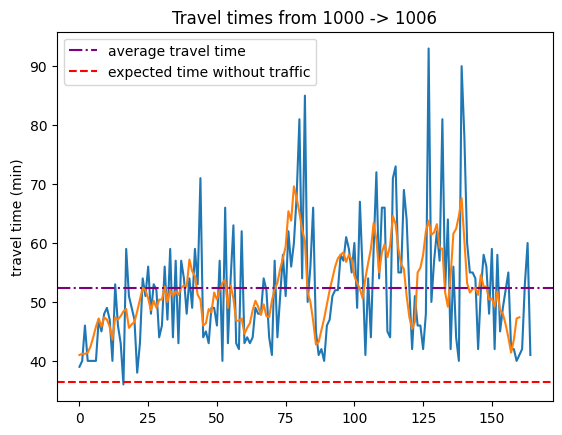

In [16]:
node_from = 1000 # 1000
node_to = 1006 # 1006
exavg = nx.shortest_path_length(gfd, node_from, node_to, weight='tt_avg')
t = gfd.nodes[node_to]['object'].times
filtje=np.zeros(len(t))
for i in leeuwarden: #leeuwarden
    filtje=np.logical_or(filtje,t[:,1]==i)
t2 = t[filtje, 0]

if traveltime_saveto:
    t2.tofile(f'./gendata/{traveltime_saveto}')

if len(t2) != 0:
    N = min(20, 5)
    print(np.ones(N)/N)
    tavg = np.convolve(t2, np.ones(N)/N, mode='valid')
    tavgavg = np.mean(tavg)
    print(f"Average travel time: {tavgavg} min")
    print(f"Travel time: {exavg:.0f} +{(tavgavg-exavg):.0f} min")
    # print(tavg)
    plt.title(f"Travel times from {node_from} -> {node_to}")
    plt.plot(t2)
    plt.plot(tavg)
    plt.axhline(y=tavgavg, ls='-.', color='purple', label='average travel time')
    plt.axhline(y=exavg, ls='--', color='red', label='expected time without traffic')
    plt.ylabel("travel time (min)")
    plt.legend()
    plt.show()

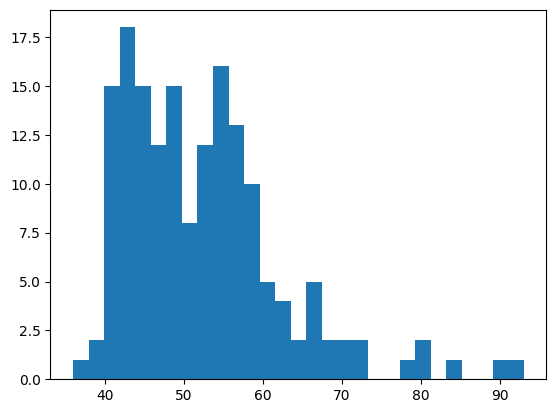

In [17]:
plt.hist(t2, bins=29)
plt.show()

In [18]:
# 149->91: 22.2
# gfd.edges[(149, 189)]['object'].leftthismin_avg

In [19]:
# gfd.edges[(93, 95)]['object'].leftthismin_avg

In [20]:
lines_gpd_copy = lines_gpd.copy()
lines_gpd = lines_gpd.explode()

line_offset = 850
line_offset2 = 150
left_shift = lines_gpd.copy()
left_shift2 = lines_gpd.copy()

# def is_rightsided(geom): # is northeast or southeast
#     dx = geom.coords[-1][0] - geom.coords[0][0]
#     return dx > 0

# left_shift['geometry'] = left_shift.geometry.apply(lambda k: k if is_rightsided(k) else k.reverse())
# manual_indices = [137, 103, 280, 164, 80, 123, 85, 86, 173, 175, 176]

def update_offset(row):
    # if row.name in manual_indices: # row.name is index
    #     return row.geometry.offset_curve(line_offset)
    return row.geometry.offset_curve(-line_offset)

def update_offset2(row):
    return row.geometry.offset_curve(-line_offset2)

left_shift['geometry'] = left_shift.apply(update_offset, axis=1)
left_shift2['geometry'] = left_shift2.apply(update_offset2, axis=1)
cities = gpd.read_file('./wegengraaf2/cities.shp').to_crs(epsg=3857)
# left_shift[left_shift['node_start'] == 142]

<timed exec>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
<timed exec>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


CPU times: total: 172 ms
Wall time: 162 ms


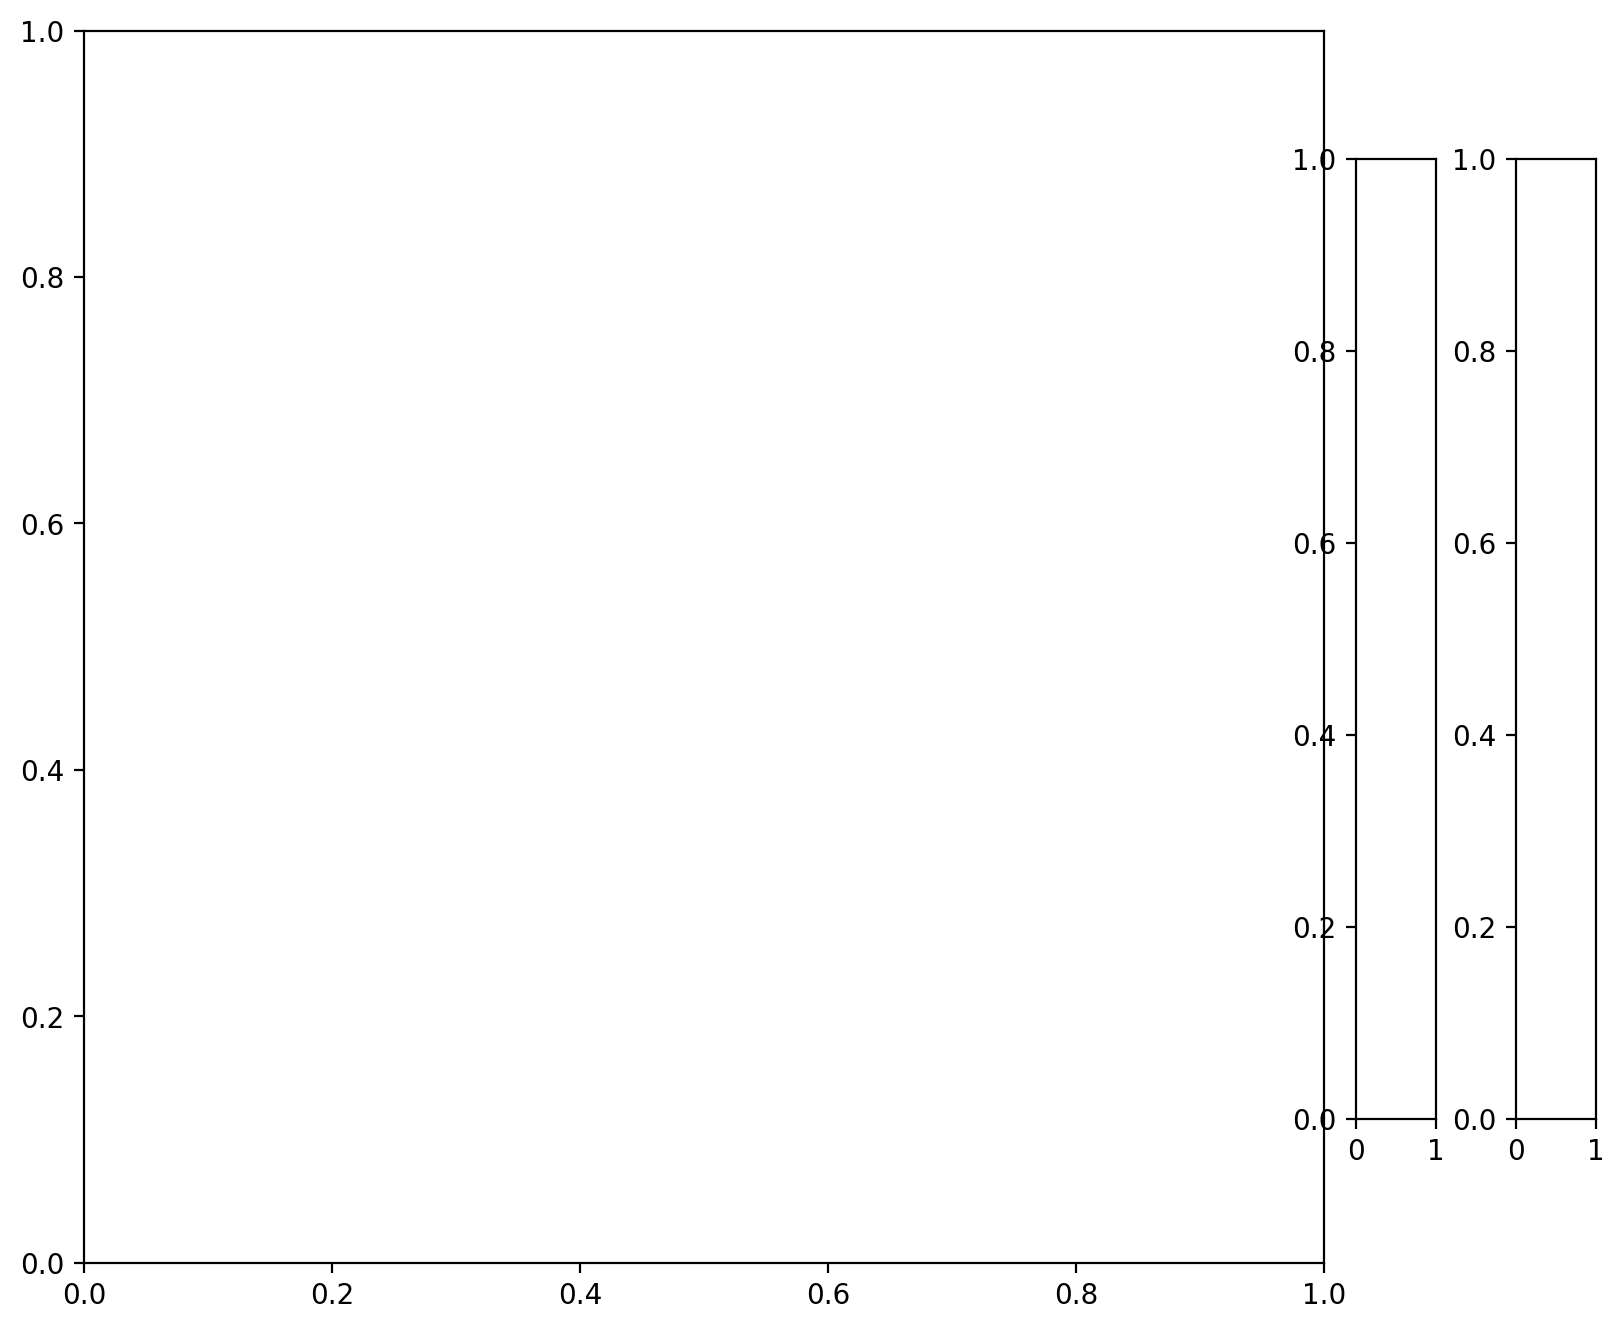

In [21]:
%%time
plt.figure(figsize=(8,8), dpi=200)
ax = plt.subplot()

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92, 0.2, 0.05, 0.6])
cax2 = plt.axes([0.92+0.1, 0.2, 0.05, 0.6])

def update(i):
    ax.clear()
    ax.set_title(f"Frame {i}")

    left_shift.plot(ax=ax, column=lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    cmap='cool',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    zorder=1)
    lines_gpd.plot(ax=ax, column=lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    zorder=1)
    
    # nodes_gpd.plot(ax=ax, markersize=10, color='black', zorder=2)
    cities.plot(ax=ax, 
            column='population')
    cities.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], size=8, ha='center', color='white', path_effects=[pe.withStroke(linewidth=4, foreground="black")]), axis=1)
        
    cx.add_basemap(ax)

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax)
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)

    # plt.tight_layout()
    plt.savefig('./img2/%02d.png' % i, dpi=200, bbox_inches='tight')
    print('%02d' % i, end=', ')

if save_to == None:
    for k in range(0, minutes_sim): # minutes_sim
        update(k)


<timed exec>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
<timed exec>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.


CPU times: total: 15.6 ms
Wall time: 20.3 ms


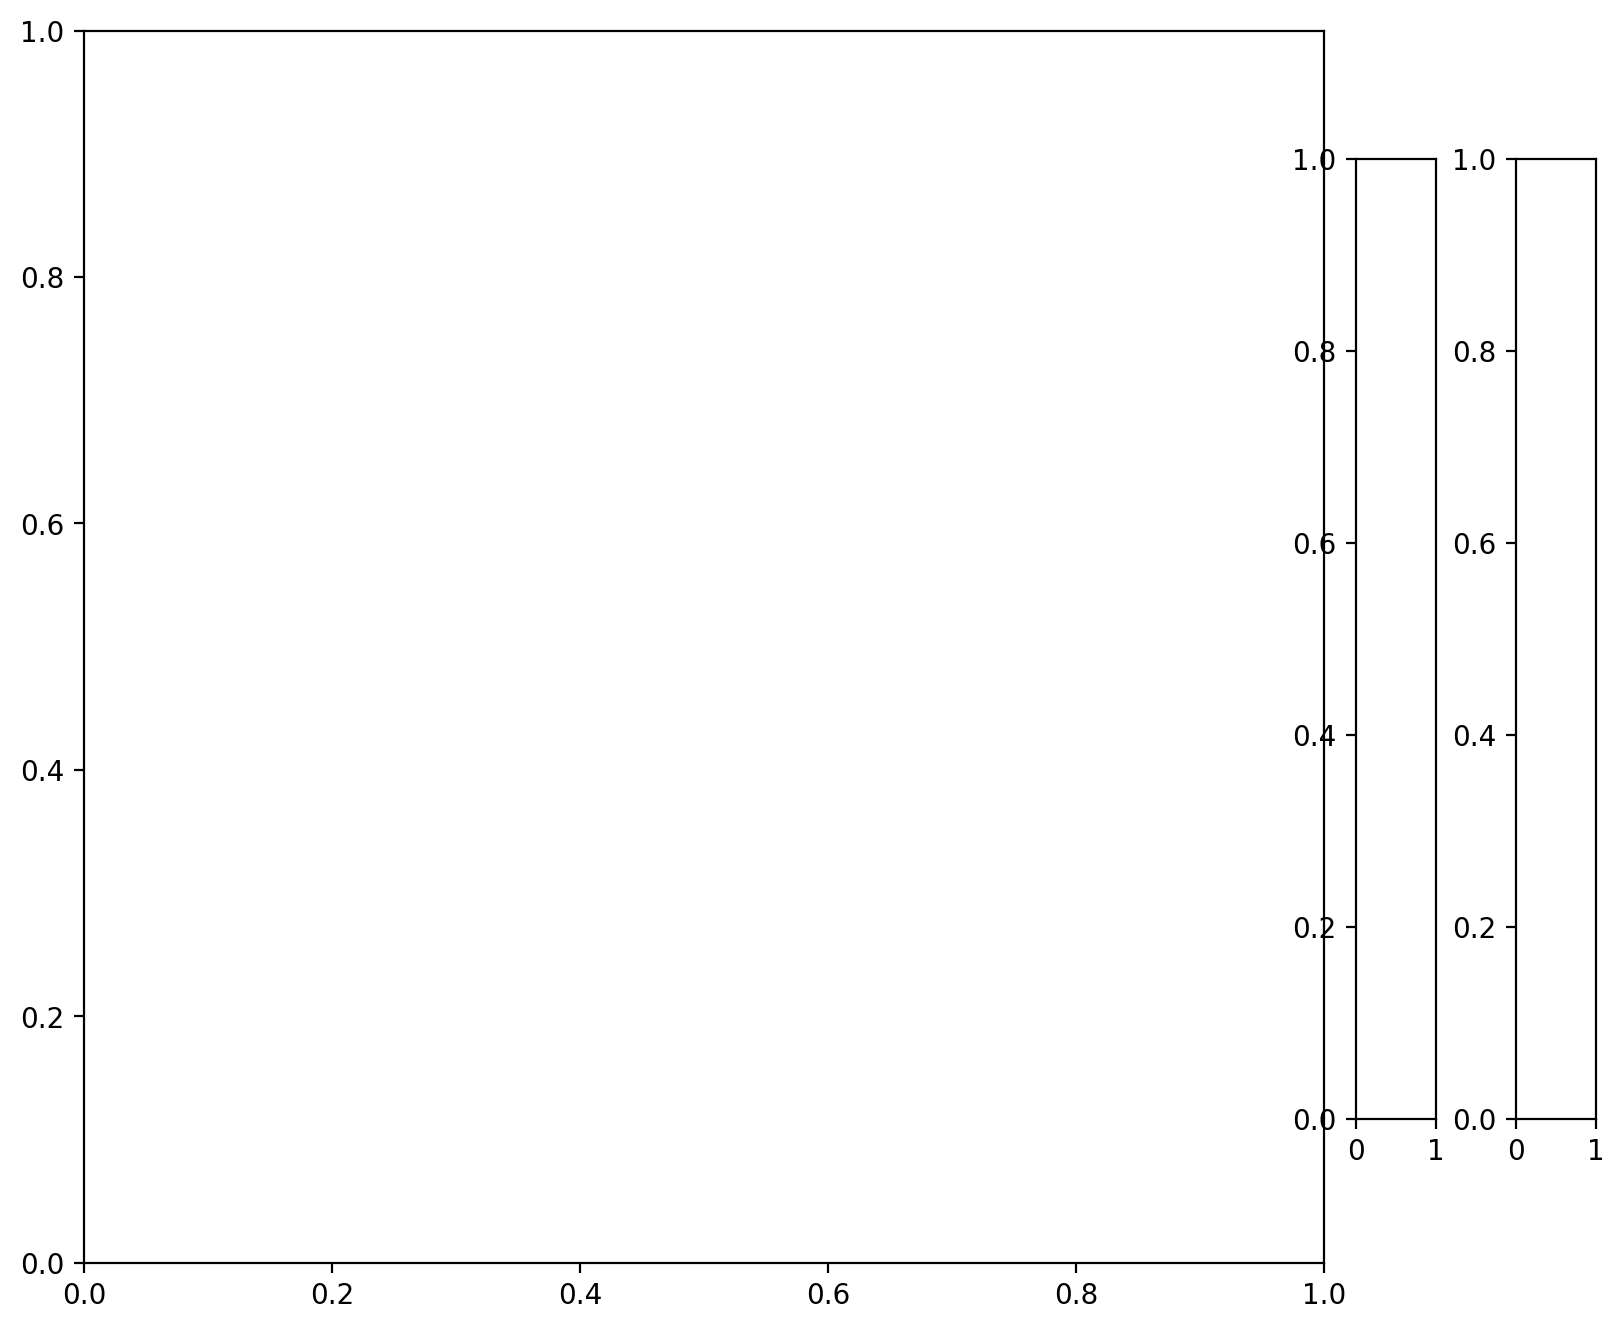

In [22]:
%%time
plt.figure(figsize=(8,8), dpi=200)
ax = plt.subplot()

cmap = plt.cm.get_cmap('autumn_r', 100)
cmap2 = plt.cm.get_cmap('cool', 100)

cax = plt.axes([0.92, 0.2, 0.05, 0.6])
cax2 = plt.axes([0.92+0.1, 0.2, 0.05, 0.6])

# left_shift2 = lines_gpd.apply(lambda r: r.geometry.offset_curve(-400), axis=1)

def update(i):
    ax.clear()
    ax.set_xlim(63.5e4, 65.25e4)
    ax.set_ylim(7.01e6, 7.025e6)
    ax.set_title(f"Frame {i} (Leeuwarden)")

    left_shift2.plot(ax=ax, column=lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    cmap='cool',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"b{i}"]/lines_gpd["capacity"],
                    zorder=1)
    lines_gpd.plot(ax=ax, column=lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    cmap='autumn_r',
                    linewidth=0.7+lines_gpd['nbanen']*1.5 + 2*lines_gpd[f"f{i}"]/lines_gpd["capacity"],
                    zorder=1)
    
    # nodes_gpd.plot(ax=ax, markersize=10, color='black', zorder=2)
    # cities.plot(ax=ax, 
    #         column='population')
    # cities.apply(lambda x: ax.annotate(text=x['name'], xy=x.geometry.centroid.coords[0], size=8, ha='center', color='white', path_effects=[pe.withStroke(linewidth=4, foreground="black")]), axis=1)
    
    cx.add_basemap(ax)

    
    bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax, ax=ax)
    bar_info = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0, vmax=100))
    bar_info._A = [] ### geen idee wat dit doet
    cbar = plt.colorbar(bar_info, cax=cax2, ax=ax)

    # plt.tight_layout()
    plt.savefig('./imgleeuw/%02d.png' % i, dpi=200, bbox_inches='tight')
    print('%02d' % i, end=', ')

if save_to == None:
    for k in range(0, minutes_sim): # minutes_sim
        update(k)


# ffmpeg -framerate 1 -i %02d.png -c:v libx264 -pix_fmt yuv420p -r 25 output.mp4 -y

----

In [23]:
# nodes_gpd[~nodes_gpd['stad_naam'].isnull()]

In [24]:
# x, y = nodes_gpd.iloc[156].geometry.coords[0]

In [25]:
# nodes_gpd[~nodes_gpd['stad_naam'].isnull()].apply(lambda r: (r['nodeID'], r['stad_naam'], r.geometry.coords[0][0], r.geometry.coords[0][1]), axis=1).to_list()

In [26]:
# nx.path_weight(gfd,[1000,248,247,255,87,179,78,10,79,114,99,112,27,28,1008],weight="tt_avg")

In [27]:
# for e in gfd.edges:
#     if  gfd.edges[e]["object"].size()<0.01*gfd.edges[e]["object"].C(): print(e,gfd.edges[e]["object"].size(),gfd.edges[e]["object"].C(),gfd.edges[e]["tt_avg"])

In [28]:
# nx.set_edge_attributes(gfd,{e: (gfd.edges[e]["object"].tt_avg()+gfd.nodes[e[0]]["object"].avg_waittime(gfd.edges[e]["object"]))*(1+gfd.edges[e]["object"].size()/gfd.edges[e]["object"].C()) for e in gfd.edges},"tt_avg") #put edge objects on the edges
# path = nx.shortest_path(gfd,1000,1008,weight="tt_avg")
# print(path)
# for j,i in enumerate(path[:-1]):
#     print(i,gfd.edges[(i,path[j+1])]["object"].C())

In [29]:
# # traffic_map["cars"] = data1[:,i]
# # traffic_map['textpromt'] = traffic_map['name'].apply(gen_text)
# fig, ax = plt.subplots(1, figsize=(15, 8),dpi = 200)
# cmap = plt.cm.get_cmap('autumn', 120)
# cmap2 = plt.cm.get_cmap('Greens', 120)

# nodes_gpd.plot( linewidth=0.1, ax=ax, edgecolor=".4")

# def update(i):
#     ax.clear()
#     lines_gpd.plot(ax=ax, column=lines_gpd[f"f{i}"]/lines_gpd["capacity"],
#                 cmap='Accent',
#                 linewidth=3,
#                 # legend=True,
#                 # legend_kwds={'label': 'Aantal banen', 'shrink': 0.6},
#                 zorder=1)
#     nodes_gpd.plot(ax=ax, markersize=25, color='black', zorder=2)


#     # ax.clear()
    
#     #plotting edges colored by fractions of capacity
#     # lines_gpd.plot(column=lines_gpd[f"f{i}"]/lines_gpd["capacity"], cmap=cmap, linewidth=0.4, ax=ax,vmin=0,vmax=1)
#     # lines_gpd.apply(lambda x: ax.annotate(text=f"{x['f59']/x['capacity']:.2f}" , xy=x.geometry.centroid.coords[0], ha='center') if x['f59']/x['capacity']>0.9 else 0, axis=1)
# anim = FuncAnimation(fig,update,interval = 100)

# #create a colorr barr
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.78])  # Adjust the position and size as needed
# bar_info = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=100))
# bar_info._A = [] ### geen idee wat dit doet
# cbar = fig.colorbar(bar_info, cax=cax)


In [30]:
# print(sources)
# for i in sources:
#     print(len(gfd.nodes[i]["object"].times),"cars arrived at", i)
#     print(len(gfd.nodes[i]["object"].buildup))

In [31]:
# for i in sources:
#     for j in sources:
#         if i==j: continue
#         data = gfd.nodes[i]["object"].times[gfd.nodes[i]["object"].times[:,1]==j,0]
#         if np.sum(gfd.nodes[i]["object"].times[:,1]==j)==0: print(f"no cars from {j} have arrived at {i}")
#         else:
#             plt.hist(data,bins=int((max(data)-min(data))))
#             plt.show()
#             print(f'average time from {j} to {i} is {np.average(data)} +/- {np.std(data)}')

### comparing to data on https://staat-van-fryslan.hub.arcgis.com/pages/bda2fb83b28b4707840ee69c05cd0146 and https://opendata.cbs.nl/statline/#/CBS/nl/dataset/82855NED/table?fromstatweb

In [32]:
# arr_forw=np.zeros(len(lines_gpd))
# arr_backw=np.zeros(len(lines_gpd))
# for index,(start,end) in enumerate(zip(lines_gpd["node_start"],lines_gpd["node_end"])):
#     # if (start,end) in gfd.edges:
#     arr_forw[index]=gfd.edges[(start,end)]["object"].leftthismin_avg
#     arr_backw[index]=gfd.edges[(end,start)]["object"].leftthismin_avg
# saved_gpd=pd.concat((lines_gpd,pd.DataFrame(arr_forw,columns=["leftforw"]),pd.DataFrame(arr_backw,columns=["leftback"])),axis=1)
# # saved_gpd.to_csv("precookeddata200m")

In [33]:
# loaded_gpd=saved_gpd
# # loaded_gpd=pd.read_csv("precookeddata200m")

In [34]:
# f=open(f"initvalresults\\runz{10}","w")
# f.write(f"settings:{spawn_hoeveelheden}\n")
# def carspermin(workday_avg,part_during_day=.8):return workday_avg*part_during_day/12/60
# def compare_data(edges,counter_id,workday_avg,name,part_during_day=.8):
#     # for i in edges: 
#     #     print(i)
#     #     print(loaded_gpd[(loaded_gpd["node_start"]==i[0])*(loaded_gpd["node_end"]==i[1])]["leftforw"].iloc[0])
#     counts=[]
#     for i in edges:
#         if len(loaded_gpd[(loaded_gpd["node_start"]==i[0])*(loaded_gpd["node_end"]==i[1])]["leftforw"])>=1: counts.append(loaded_gpd[(loaded_gpd["node_start"]==i[0])*(loaded_gpd["node_end"]==i[1])]["leftforw"].iloc[0])
#         else: counts.append(loaded_gpd[(loaded_gpd["node_start"]==i[1])*(loaded_gpd["node_end"]==i[0])]["leftback"].iloc[0])
#     line=f"counter {counter_id}:{carspermin(workday_avg,part_during_day)}, model: {sum(counts)} {counts} name:{name}"
#     print(line)
#     return carspermin(workday_avg,part_during_day)-sum(counts),line
# # def test_Aweg(lines_gpd,wegnr,measurement):
# #     """compares the average of the flow of all roadsegments of a highway and compares it with an hourly measurement on the real road"""
# #     model,real=np.average(lines_gpd["leftback"][lines_gpd["wegnr"]==wegnr])+np.average(lines_gpd["leftforw"][lines_gpd["wegnr"]==wegnr]),measurement/60
# #     line=f"A{wegnr}:{real},{model=}"
# #     return real-model, line
# counters2=[([(202,35),(35,202)],101608,24097,.807,.5,"oost Leeuwarden"),([(72,173),(173,72)],101625,8858,.815,1,"leeuwarden ZW"),([(205,206),(206,205),(204,205),(205,204)],(101612,101647),19083+7763,.818,1,"bergum ZO/ZW"),([(155,205),(205,155)],101615,18749,.813,1,"Bergum NW"),([(240,241),(241,240)],101606,11187,.842,1,"sneek NO"),([(164,82),(82,164)],101607,10613,.826,1,"sneek Z"),([(502,503),(503,502)],101650,4393,.805,1,"Heerenveen Zuid") \
#           ,([(144,172),(172,144)],101673,9766,.798,1,"Drachten N"),([(155,63),(63,155)],101614,14396,.822,1,"Dokkum Z"),([(176,63),(63,176)],101671,9950,.844,1,"Dokkum W"),([(180,207),(207,180)],101601,9822,.817,1,"Wolvega O"),([(71,102),(102,71)],101668,11147,.811,1,"Lemmer W"),([(136,134),(134,136)],101676,6883,.829,1,"Harlingen O"),(([(136,16),(16,136)],101643,2707,.798,1,"Harlingen N")),\
#             ([(137,14),(14,137)],101637,3407,.798,1,"FranekerN"),([(75,45),(45,75)],101636,2948,.834,1,"Franeker ZO"),([(57,152),(152,57)],101623,8660,.816,1,"Bolsward Z"),([(115,77),(77,115)],101624,8445,.816,1,"Bolsward N"),([(219,160),(160,219),(178,160),(160,178)],(101674,101656),16267+5077,.828,1,"Oosterwolde N/W")]
# counters_A=[("006",(1946+1870+1647)/3),("007",(1466+1457+1506)/3),("031",(894+877+978)/3),("032",(1209+1276+1447)/3)]
# counters=[([(202,35),(35,202)],101608,24097,.807,1,"oost Leeuwarden"),([(72,173),(173,72)],101625,8858,.815,1,"leeuwarden ZW"),([(205,206),(206,205)],101612,19083,.811,1,"bergum ZO"),([(155,205),(205,155)],101615,18749,.813,1,"Bergum NW"),([(204,205),(205,204)],101647,7763,.823,1,"Bergum ZW"),([(240,241),(241,240)],101606,11187,.842,1,"sneek NO"),([(164,82),(82,164)],101607,10613,.826,1,"sneek Z"),([(502,503),(503,502)],101650,4393,.805,1,"Heerenveen Zuid") \
#           ,([(144,172),(172,144)],101673,9766,.798,1,"Drachten N"),([(155,63),(63,155)],101614,14396,.822,1,"Dokkum Z"),([(176,63),(63,176)],101671,9950,.844,1,"Dokkum W"),([(140,76),(76,140)],101635,3561,.83,1,""),([(180,207),(207,180)],101601,9822,.817,1,"Wolvega O"),([(71,102),(102,71)],101668,11147,.811,1,"Lemmer W"),([(136,134),(134,136)],101676,6883,.829,1,"Harlingen O"),(([(136,16),(16,136)],101643,2707,.798,1,"Harlingen N")),\
#             ([(137,14),(14,137)],101637,3407,.798,1,"FranekerN"),([(75,45),(45,75)],101636,2948,.834,1,"Franeker ZO"),([(57,152),(152,57)],101623,8660,.816,1,"Bolsward Z"),([(115,77),(77,115)],101624,8445,.816,1,"Bolsward N"),([(219,160),(160,219)],101674,16267,.828,1,"Oosterwolde N"),([(178,160),(160,178)],101656,5077,.861,1,"Oosterwolde W")]
# sq_sum=0
# for edges,counter_id,workday_avg,part_during_day,weight,name in counters:
#     dist,line=compare_data(edges,counter_id,workday_avg,name,part_during_day)
#     f.write(line+"\n")
#     sq_sum+=weight*dist**2
# # for wegnr,measurement in counters_A:
# #     dist,line=test_Aweg(lines_gpd,wegnr,measurement)
# #     f.write(line+"\n")
# #     sq_sum+=dist**2
# f.write(f"{np.sqrt(sq_sum)}")
# f.close()
# print (np.sqrt(sq_sum))

In [35]:
# def test_Aweg(lines_gpd,wegnr,measurement):
#     """compares the average of the flow of all roadsegments of a highway and compares it with an hourly measurement on the real road"""
#     model,real=np.average(lines_gpd["leftback"][lines_gpd["wegnr"]==wegnr])+np.average(lines_gpd["leftforw"][lines_gpd["wegnr"]==wegnr]),measurement/60
#     line=f"A{wegnr}:{real},{model=}"
#     return real-model, line
# wegnr,measurement = counters_A[2]
# dist,line=test_Aweg(loaded_gpd,wegnr,measurement)
# print(line)

In [36]:
# nx.shortest_path(gfd,1000,1004)

In [37]:
# loaded_gpd=pd.read_csv("precookeddata200m")

In [38]:
# def test_Aweg(lines_gpd,wegnr,measurement):
#     """compares the average of the flow of all roadsegments of a highway and compares it with an hourly measurement on the real road"""
#     model,real=np.average(lines_gpd["leftback"][lines_gpd["wegnr"]==wegnr])+np.average(lines_gpd["leftforw"][lines_gpd["wegnr"]==wegnr]),measurement/60
#     line=f"A{wegnr}:{real},{model=}"
#     return real-model, line
# counters_A=[("006",(1946+1870+1647)/3),("007",(1466+1457+1506)/3),("031",(894+877+978)/3),("032",(1209+1276+1447)/3)]
# for wegnr,measurement in counters_A:
#     dist,line=test_Aweg(loaded_gpd,wegnr,measurement)
#     print(dist,line)

In [39]:
# locations={1000: 'Leeuwarden',
#  1001: 'Drachten',
#  1002: 'Sneek',
#  1004: 'Harlingen',
#  1005: 'Joure',
#  1006: 'Wolvega',
#  1007: 'Franeker',
#  1008: 'Dokkum',
#  1009: 'Lemmer',
#  1010: 'Bolsward',
#  1011: 'Burgum',
#  1003: 'Heerenveen',
#  160: None,
#  199: "Afsluitdijk"}